<a href="https://colab.research.google.com/github/salberts-onesvs/ML_Gatekeeper/blob/main/photo_quality_gatekeeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Photo Quality Gatekeeper — Binary Classifier

**Goal:** Train a binary classifier to filter photo quality before sending to Claude OCR.

**Model Decision:**
- **GOOD (0)** — Photo quality is acceptable (clear, in-focus, adequate lighting)
- **BAD (1)** — Photo quality is poor (blurry, dark, severe glare, extreme angle)

**Key Insight:** Model judges PHOTO QUALITY, not label readability.
- Damaged/faded labels with good photo quality → GOOD (let Claude diagnose)
- Perfect labels with poor photo quality → BAD (retake needed)

**Architecture:** MobileNetV2 with transfer learning (lightweight, fast inference)

**Output:** Single sigmoid (0.0-1.0 quality score)
- Score < 0.3 → GOOD quality
- Score > 0.7 → BAD quality
- 0.3-0.7 → Tune threshold based on validation metrics

**Exports:**
- `.keras` format (standard)
- `.tflite` format (deployment - JavaScript/Flutter)

---

**Run in Google Colab with GPU enabled:**
Runtime → Change runtime type → GPU

## 1. Setup & Upload Data

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.19.0
GPU available: True


In [2]:
# Upload your training data zip file.
# Expected structure inside the zip:
#   photos/good/*.jpg  (clear, in-focus photos)
#   photos/bad/*.jpg   (blurry, dark, glare, extreme angle)

from google.colab import files

print("Upload your training data zip (containing good/ and bad/ folders):")
uploaded = files.upload()

zip_filename = list(uploaded.keys())[0]
print(f"Uploaded: {zip_filename}")

Upload your training data zip (containing good/ and bad/ folders):


Saving gatekeeper.zip to gatekeeper.zip
Uploaded: gatekeeper.zip


In [3]:
# Extract the zip
with zipfile.ZipFile(zip_filename, 'r') as z:
    z.extractall('training_data')

# Auto-detect the data directory structure
# Supports: training_data/good & training_data/bad
#       or: training_data/gatekeeper/good & training_data/gatekeeper/bad
if os.path.isdir('training_data/gatekeeper/good'):
    DATA_DIR = 'training_data/gatekeeper'
elif os.path.isdir('training_data/good'):
    DATA_DIR = 'training_data'
else:
    # List what was extracted to help debug
    for root, dirs, _files in os.walk('training_data'):
        for d in dirs:
            print(os.path.join(root, d))
    raise FileNotFoundError("Could not find good/ and bad/ folders. Check zip structure.")

good_count = len(os.listdir(os.path.join(DATA_DIR, 'good')))
bad_count = len(os.listdir(os.path.join(DATA_DIR, 'bad')))
total_count = good_count + bad_count
print(f"Data directory: {DATA_DIR}")
print(f"Good photos: {good_count}")
print(f"Bad photos:  {bad_count}")
print(f"Total:       {total_count}")

# Check for class imbalance and compute class weights
imbalance_ratio = max(good_count, bad_count) / min(good_count, bad_count)
if imbalance_ratio > 1.5:
    print(f"\n⚠️  Class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
    print("   Using class weights to compensate during training.")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f}:1)")

# Compute class weights: sklearn-style balanced weighting
# Classes are alphabetical: bad=0, good=1
# Formula: weight_i = total / (num_classes * count_i)
CLASS_WEIGHTS = {
    0: total_count / (2 * bad_count),   # bad class weight
    1: total_count / (2 * good_count),  # good class weight
}
print(f"\nClass weights: bad(0)={CLASS_WEIGHTS[0]:.3f}, good(1)={CLASS_WEIGHTS[1]:.3f}")
print("   → Minority class gets higher weight so the model doesn't ignore it")

Data directory: training_data/gatekeeper
Good photos: 673
Bad photos:  689
Total:       1362

✓ Classes are reasonably balanced (ratio: 1.02:1)

Class weights: bad(0)=0.988, good(1)=1.012
   → Minority class gets higher weight so the model doesn't ignore it


## 2. Data Loading & Augmentation

In [4]:
# Configuration
IMG_SIZE = 224        # MobileNetV2 default input size
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42

In [5]:
# Load training set (binary: bad=0, good=1 — alphabetical)
train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',  # Binary classification
)

# Load validation set
val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")
print(f"Class mapping: {class_names[0]}=0 (bad quality), {class_names[1]}=1 (good quality)")
print(f"Model output: 0.0 = bad, 1.0 = good")

Found 1362 files belonging to 2 classes.
Using 1090 files for training.
Found 1362 files belonging to 2 classes.
Using 272 files for validation.
Classes: ['bad', 'good']
Class mapping: bad=0 (bad quality), good=1 (good quality)
Model output: 0.0 = bad, 1.0 = good


/tmp/ipython-input-334612935.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_value = float(labels[i].numpy())  # Convert to Python float


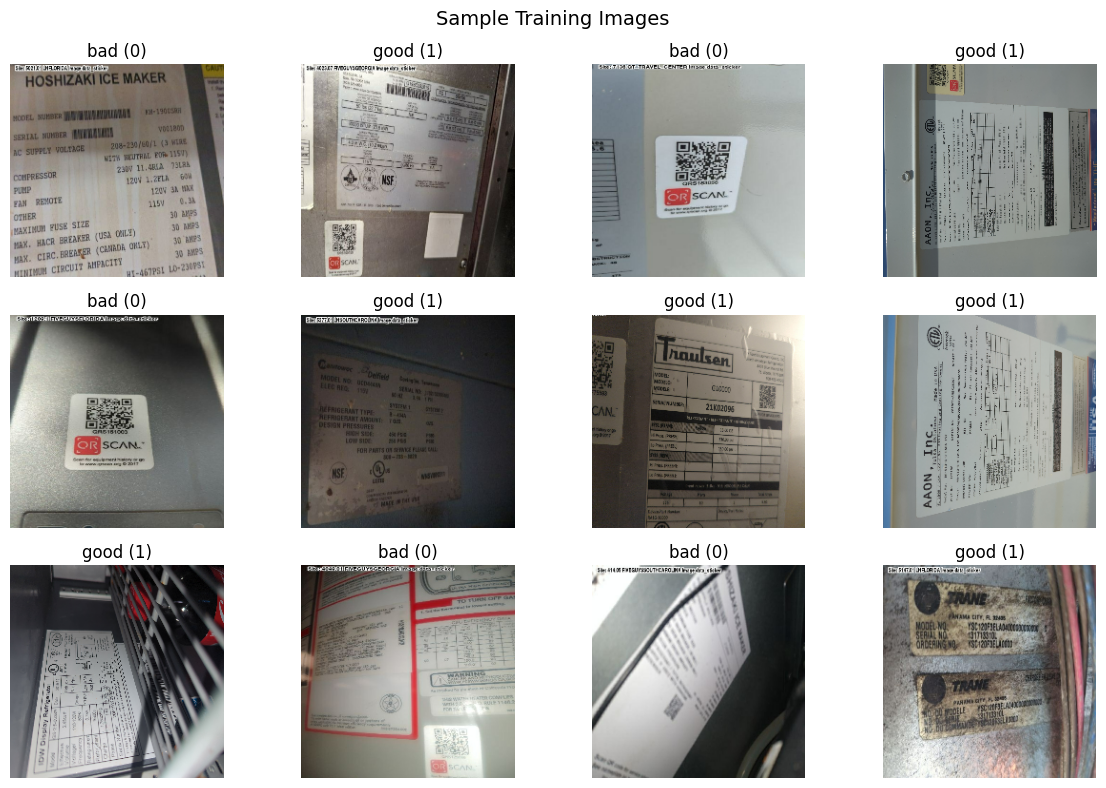

In [6]:
# Preview a batch of training images
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(12, len(images))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label_value = float(labels[i].numpy())  # Convert to Python float
        label_idx = int(label_value)
        plt.title(f"{class_names[label_idx]} ({label_value:.0f})")
        plt.axis('off')
plt.suptitle('Sample Training Images', fontsize=14)
plt.tight_layout()
plt.show()

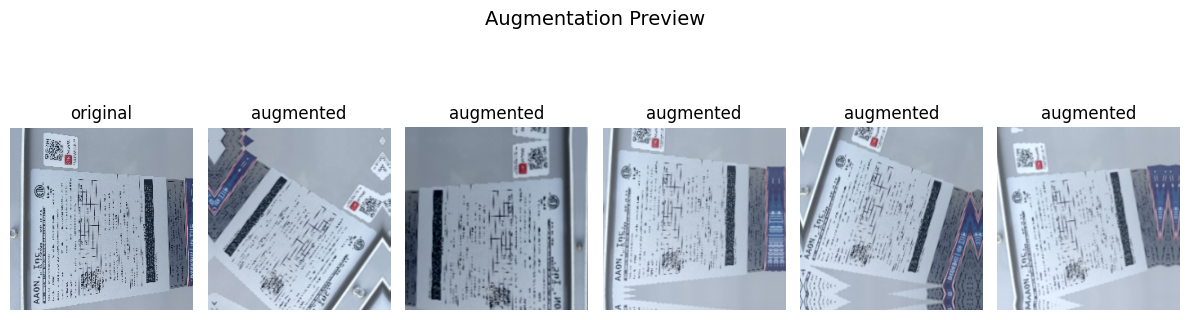

In [7]:
# Data augmentation layer (applied only during training)
# Simulates real-world photo variations
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),      # ±15° rotation
    layers.RandomZoom(0.1),            # ±10% zoom
    layers.RandomBrightness(0.2),      # ±20% brightness
    layers.RandomContrast(0.2),        # ±20% contrast
    layers.RandomTranslation(0.1, 0.1),# ±10% shift (simulates off-center framing)
], name='data_augmentation')

# Preview augmented images
plt.figure(figsize=(12, 4))
for images, _ in train_ds.take(1):
    original = images[0]
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        if i == 0:
            plt.imshow(original.numpy().astype('uint8'))
            plt.title('original')
        else:
            augmented = data_augmentation(tf.expand_dims(original, 0), training=True)
            plt.imshow(augmented[0].numpy().astype('uint8'))
            plt.title('augmented')
        plt.axis('off')
plt.suptitle('Augmentation Preview', fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
# Performance optimization: prefetch data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Build Model (MobileNetV2 + Binary Classification)

In [9]:
# Load pre-trained MobileNetV2 (without top classification layer)
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
)

# Freeze the base model — we'll only train the new head initially
base_model.trainable = False

print(f"Base model layers: {len(base_model.layers)}")
print(f"Base model params: {base_model.count_params():,}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model layers: 154
Base model params: 2,257,984


In [10]:
# Build the full model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Augmentation (only active during training)
x = data_augmentation(inputs)

# MobileNetV2 preprocessing (scales pixels to [-1, 1])
x = keras.applications.mobilenet_v2.preprocess_input(x)

# Base model (frozen)
x = base_model(x, training=False)

# Classification head — binary output with sigmoid
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid', name='quality_score')(x)

model = keras.Model(inputs, outputs, name='photo_quality_gatekeeper')
model.summary()

Model: "photo_quality_gatekeeper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quality_score (Dense)           │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Compile Model

In [11]:
# Compile with binary crossentropy loss
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
    ]
)

print("Model compiled with binary_crossentropy loss")
print("Metrics: accuracy, precision (minimize false positives), recall (minimize false negatives)")

Model compiled with binary_crossentropy loss
Metrics: accuracy, precision (minimize false positives), recall (minimize false negatives)


## 5. Phase 1: Train Classification Head (Frozen Base)

In [12]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Phase 1: Train only the new classification head
print("\n=== Phase 1: Training classification head (base frozen) ===")
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS,
)

phase1_epochs = len(history_phase1.history['loss'])
print(f"Phase 1 completed in {phase1_epochs} epochs")


=== Phase 1: Training classification head (base frozen) ===
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 278ms/step - accuracy: 0.6850 - loss: 0.6370 - precision: 0.6581 - recall: 0.6426 - val_accuracy: 0.7978 - val_loss: 0.4368 - val_precision: 0.7363 - val_recall: 0.9504 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7909 - loss: 0.4515 - precision: 0.7617 - recall: 0.8033 - val_accuracy: 0.8125 - val_loss: 0.3954 - val_precision: 0.7711 - val_recall: 0.9078 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8249 - loss: 0.3986 - precision: 0.7934 - recall: 0.8515 - val_accuracy: 0.8125 - val_loss: 0.3709 - val_precision: 0.7744 - val_recall: 0.9007 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8008 - loss: 0.4099 - precision: 0.7819 - recall: 0.7988 - val_accuracy: 0.8235 - val_loss: 0.3722 - val_precision: 0.8079 - val_recall: 0.8652 - learning_rate: 0.0010
Epoch

## 6. Phase 2: Fine-tune (Unfreeze Top Layers)

In [13]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Freeze the first 100 layers (keep early features frozen)
for layer in base_model.layers[:100]:
    layer.trainable = False

trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Fine-tuning {trainable_count} layers (out of {len(base_model.layers)})")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')],
)

print("Model recompiled with lr=0.0001 for fine-tuning")

Fine-tuning 54 layers (out of 154)
Model recompiled with lr=0.0001 for fine-tuning


In [14]:
# Phase 2: Fine-tune the model
print("\n=== Phase 2: Fine-tuning top layers ===")
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    initial_epoch=phase1_epochs,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS,
)

phase2_epochs = len(history_phase2.history['loss'])
print(f"Phase 2 completed in {phase2_epochs} epochs")


=== Phase 2: Fine-tuning top layers ===
Epoch 11/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.7281 - loss: 0.6053 - precision: 0.8400 - recall: 0.5089 - val_accuracy: 0.7831 - val_loss: 0.5478 - val_precision: 0.7113 - val_recall: 0.9787 - learning_rate: 1.0000e-04
Epoch 12/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.8341 - loss: 0.3643 - precision: 0.8234 - recall: 0.8468 - val_accuracy: 0.7978 - val_loss: 0.5215 - val_precision: 0.7240 - val_recall: 0.9858 - learning_rate: 1.0000e-04
Epoch 13/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8588 - loss: 0.3317 - precision: 0.8482 - recall: 0.8600 - val_accuracy: 0.8199 - val_loss: 0.4435 - val_precision: 0.7556 - val_recall: 0.9645 - learning_rate: 1.0000e-04
Epoch 14/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.8623 - loss: 0.3130 - precision: 0.8578 - recall: 0.8727 - val_accuracy: 0.8235 - val_loss: 0.4668 - val_precision: 0.7627 - val_recall: 0.9574 - learning_rate: 1.0000e-04
Ep

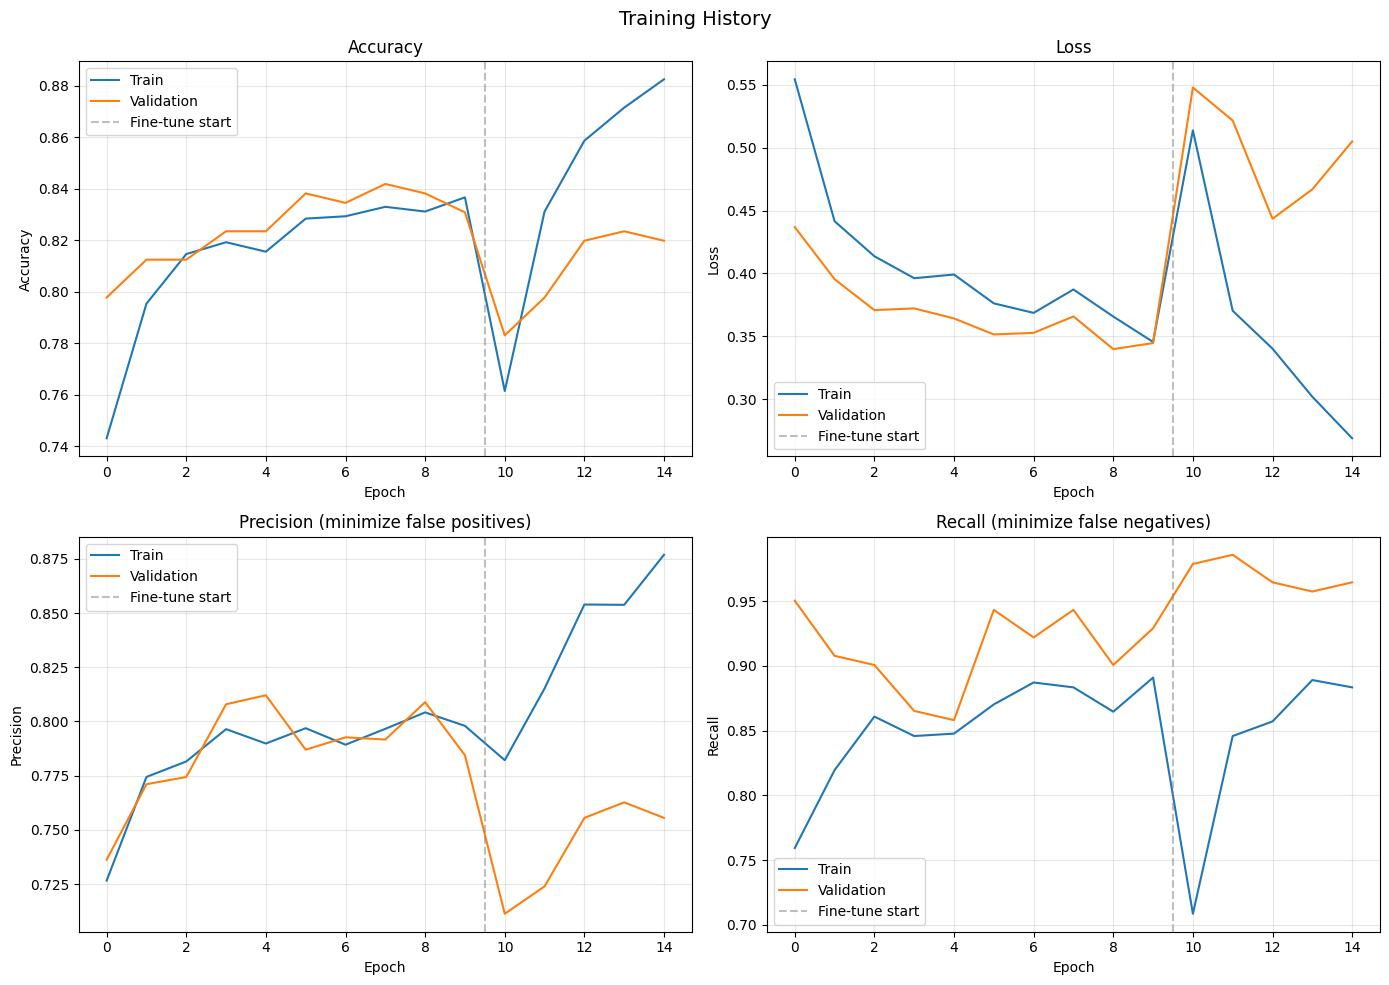


Final Training Metrics:
  Accuracy:  0.8826
  Precision: 0.8769 (of photos we accept, how many are actually good?)
  Recall:    0.8835 (of actually good photos, how many do we accept?)

Final Validation Metrics:
  Accuracy:  0.8199
  Precision: 0.7556
  Recall:    0.9645


In [15]:
# Combine training histories
history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'precision': history_phase1.history['precision'] + history_phase2.history['precision'],
    'val_precision': history_phase1.history['val_precision'] + history_phase2.history['val_precision'],
    'recall': history_phase1.history['recall'] + history_phase2.history['recall'],
    'val_recall': history_phase1.history['val_recall'] + history_phase2.history['val_recall'],
}

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].plot(history['accuracy'], label='Train')
axes[0, 0].plot(history['val_accuracy'], label='Validation')
axes[0, 0].axvline(x=phase1_epochs - 0.5, color='gray', linestyle='--', alpha=0.5, label='Fine-tune start')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history['loss'], label='Train')
axes[0, 1].plot(history['val_loss'], label='Validation')
axes[0, 1].axvline(x=phase1_epochs - 0.5, color='gray', linestyle='--', alpha=0.5, label='Fine-tune start')
axes[0, 1].set_title('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history['precision'], label='Train')
axes[1, 0].plot(history['val_precision'], label='Validation')
axes[1, 0].axvline(x=phase1_epochs - 0.5, color='gray', linestyle='--', alpha=0.5, label='Fine-tune start')
axes[1, 0].set_title('Precision (minimize false positives)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history['recall'], label='Train')
axes[1, 1].plot(history['val_recall'], label='Validation')
axes[1, 1].axvline(x=phase1_epochs - 0.5, color='gray', linestyle='--', alpha=0.5, label='Fine-tune start')
axes[1, 1].set_title('Recall (minimize false negatives)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Metrics:")
print(f"  Accuracy:  {history['accuracy'][-1]:.4f}")
print(f"  Precision: {history['precision'][-1]:.4f} (of photos we accept, how many are actually good?)")
print(f"  Recall:    {history['recall'][-1]:.4f} (of actually good photos, how many do we accept?)")
print(f"\nFinal Validation Metrics:")
print(f"  Accuracy:  {history['val_accuracy'][-1]:.4f}")
print(f"  Precision: {history['val_precision'][-1]:.4f}")
print(f"  Recall:    {history['val_recall'][-1]:.4f}")

## 7. Threshold Analysis

In [16]:
# Collect all validation predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

print(f"Collected {len(y_true)} validation predictions")

Collected 272 validation predictions


In [17]:
# Test different thresholds
print("\n=== Threshold Analysis ===")
print("Finding optimal threshold for production deployment...\n")

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for threshold in thresholds_to_test:
    y_pred = (y_pred_probs >= threshold).astype(int)

    # Calculate metrics
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fp_rate': fp / len(y_true),  # False positive rate (bad photos accepted)
    })

    print(f"Threshold: {threshold:.1f}")
    print(f"  Accuracy:  {accuracy:.3f}")
    print(f"  Precision: {precision:.3f} (minimize false positives - bad photos accepted)")
    print(f"  Recall:    {recall:.3f} (minimize false negatives - good photos rejected)")
    print(f"  F1 Score:  {f1:.3f}")
    print(f"  FP Rate:   {fp/(tp+fp):.1%} ({fp} bad photos would be sent to Claude)" if (tp+fp) > 0 else "  FP Rate:   N/A")
    print()

# Recommend threshold
# For a gatekeeper, prioritize precision (minimize bad photos sent to Claude)
best_result = max(results, key=lambda x: x['f1'])  # Balanced approach
high_precision = max(results, key=lambda x: x['precision'])  # Minimize false positives

print("\n=== RECOMMENDATIONS ===")
print(f"\n1. BALANCED (maximize F1): threshold = {best_result['threshold']:.1f}")
print(f"   - Accuracy: {best_result['accuracy']:.1%}, Precision: {best_result['precision']:.1%}, Recall: {best_result['recall']:.1%}")
print(f"   - Use when: You want balanced performance")

print(f"\n2. STRICT (maximize precision): threshold = {high_precision['threshold']:.1f}")
print(f"   - Accuracy: {high_precision['accuracy']:.1%}, Precision: {high_precision['precision']:.1%}, Recall: {high_precision['recall']:.1%}")
print(f"   - Use when: Minimizing Claude API costs is priority")
print(f"   - Trade-off: May reject more good photos (techs retake more often)")

print(f"\n💡 SUGGESTION: Start with threshold = {best_result['threshold']:.1f}, then tune based on real-world feedback")


=== Threshold Analysis ===
Finding optimal threshold for production deployment...

Threshold: 0.3
  Accuracy:  137.875
  Precision: 0.518 (minimize false positives - bad photos accepted)
  Recall:    0.688 (minimize false negatives - good photos rejected)
  F1 Score:  0.591
  FP Rate:   48.2% (24497 bad photos would be sent to Claude)

Threshold: 0.4
  Accuracy:  137.618
  Precision: 0.518 (minimize false positives - bad photos accepted)
  Recall:    0.662 (minimize false negatives - good photos rejected)
  F1 Score:  0.581
  FP Rate:   48.2% (23580 bad photos would be sent to Claude)

Threshold: 0.5
  Accuracy:  137.618
  Precision: 0.518 (minimize false positives - bad photos accepted)
  Recall:    0.662 (minimize false negatives - good photos rejected)
  F1 Score:  0.581
  FP Rate:   48.2% (23580 bad photos would be sent to Claude)

Threshold: 0.6
  Accuracy:  137.471
  Precision: 0.518 (minimize false positives - bad photos accepted)
  Recall:    0.647 (minimize false negatives - 

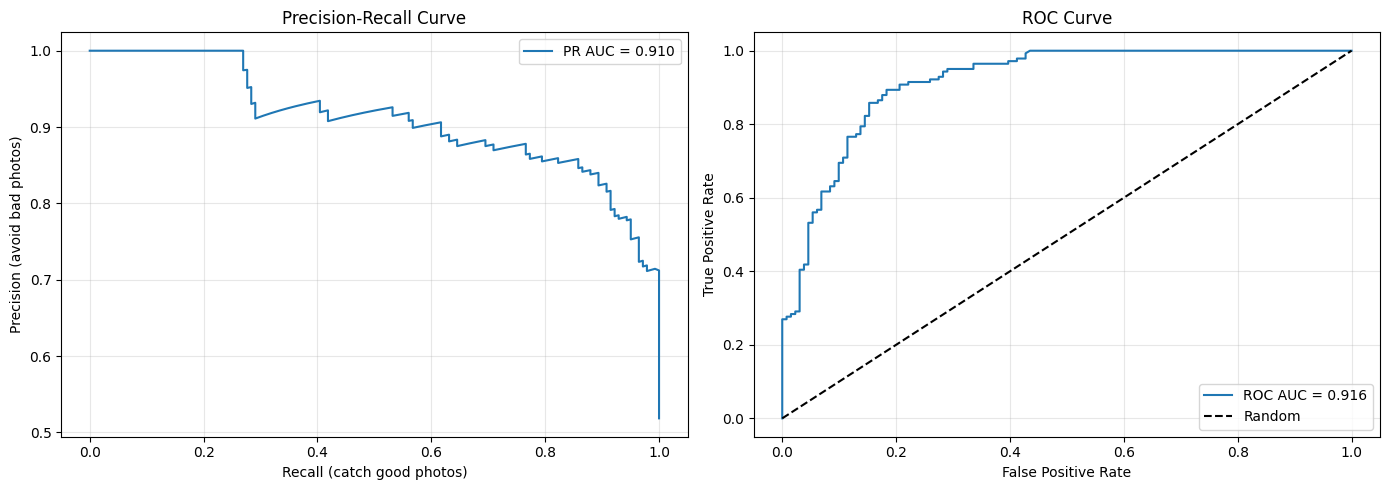

In [18]:
# Plot Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall_curve, precision_curve)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall_curve, precision_curve, label=f'PR AUC = {pr_auc:.3f}')
ax1.set_xlabel('Recall (catch good photos)')
ax1.set_ylabel('Precision (avoid bad photos)')
ax1.set_title('Precision-Recall Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ROC curve
ax2.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Evaluation with Recommended Threshold

In [19]:
# Use the recommended threshold
RECOMMENDED_THRESHOLD = 0.5
y_pred = (y_pred_probs >= RECOMMENDED_THRESHOLD).astype(int)

# Classification report
print(f"\n=== Evaluation with threshold = {RECOMMENDED_THRESHOLD} ===")
print("\nClassification Report:")
print("=" * 60)
print(classification_report(
    y_true,
    y_pred,
    target_names=['bad (0)', 'good (1)'],
    digits=3
))


=== Evaluation with threshold = 0.5 ===

Classification Report:
              precision    recall  f1-score   support

     bad (0)      0.946     0.664     0.780       131
    good (1)      0.756     0.965     0.847       141

    accuracy                          0.820       272
   macro avg      0.851     0.814     0.814       272
weighted avg      0.847     0.820     0.815       272



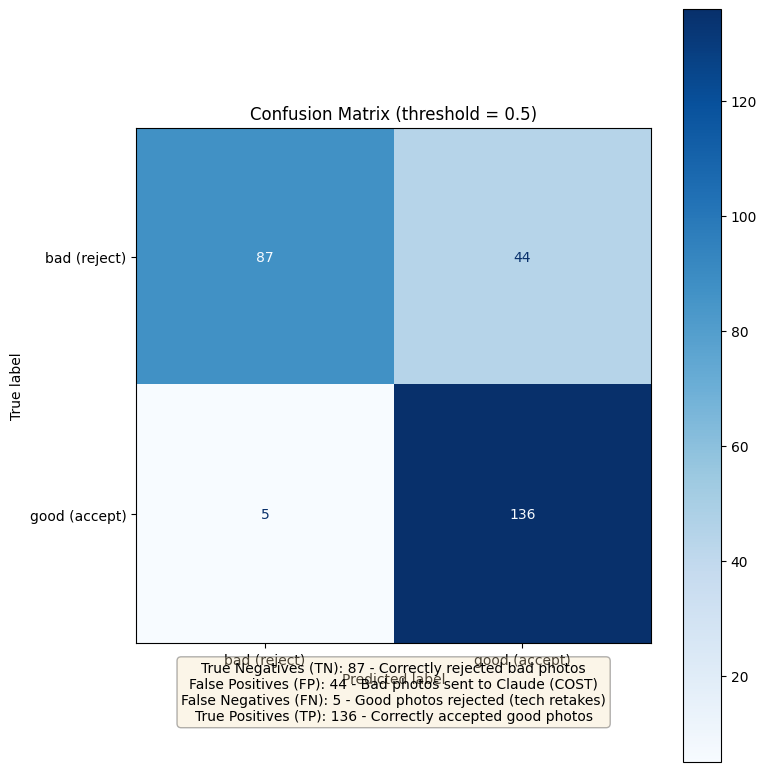


Validation: 37432/272 correct (13761.8%)

Cost Analysis:
  44 bad photos would be sent to Claude (false positives)
  5 good photos would be rejected unnecessarily (false negatives)
  At $0.02/photo: $0.88 wasted per validation set


In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['bad (reject)', 'good (accept)']
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (threshold = {RECOMMENDED_THRESHOLD})')

# Add interpretation
tn, fp, fn, tp = cm.ravel()
plt.text(0.5, -0.15,
         f"True Negatives (TN): {tn} - Correctly rejected bad photos\n"
         f"False Positives (FP): {fp} - Bad photos sent to Claude (COST)\n"
         f"False Negatives (FN): {fn} - Good photos rejected (tech retakes)\n"
         f"True Positives (TP): {tp} - Correctly accepted good photos",
         ha='center', transform=ax.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# Summary stats
total = len(y_true)
correct = (y_pred == y_true).sum()
print(f"\nValidation: {correct}/{total} correct ({correct/total*100:.1f}%)")
print(f"\nCost Analysis:")
print(f"  {fp} bad photos would be sent to Claude (false positives)")
print(f"  {fn} good photos would be rejected unnecessarily (false negatives)")
print(f"  At $0.02/photo: ${fp * 0.02:.2f} wasted per validation set")

/tmp/ipython-input-2240801846.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[i].numpy())


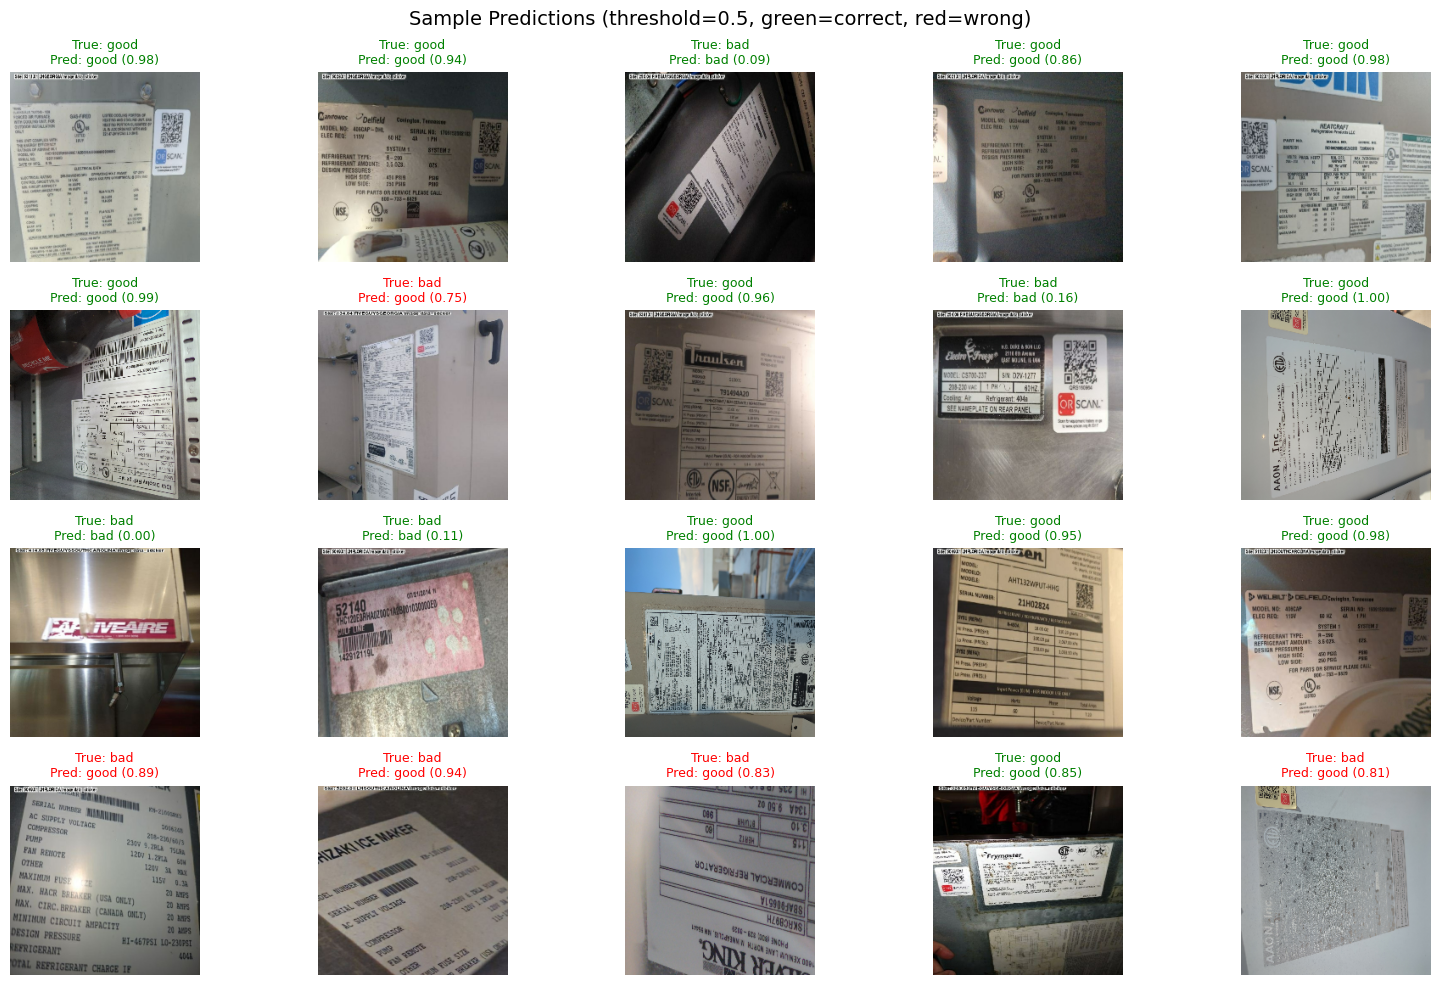

In [21]:
# Sample predictions on validation images
plt.figure(figsize=(16, 10))
shown = 0
for images, labels in val_ds:
    preds = model.predict(images, verbose=0).flatten()
    for i in range(len(images)):
        if shown >= 20:
            break
        ax = plt.subplot(4, 5, shown + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        true_label = int(labels[i].numpy())
        pred_score = preds[i]
        pred_label = int(pred_score >= RECOMMENDED_THRESHOLD)

        true_name = class_names[true_label]
        pred_name = class_names[pred_label]

        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'True: {true_name}\nPred: {pred_name} ({pred_score:.2f})',
                  color=color, fontsize=9)
        plt.axis('off')
        shown += 1
    if shown >= 20:
        break

plt.suptitle(f'Sample Predictions (threshold={RECOMMENDED_THRESHOLD}, green=correct, red=wrong)',
             fontsize=14)
plt.tight_layout()
plt.show()

## 9. Export Model

In [22]:
# Save as .keras format (native Keras 3.x format)
keras_path = 'photo_quality_gatekeeper.keras'
model.save(keras_path)
keras_size = os.path.getsize(keras_path) / (1024 * 1024)
print(f"✓ Saved Keras model: {keras_path} ({keras_size:.1f} MB)")

# Save weights separately (for reconstruction)
weights_path = 'photo_quality_gatekeeper.weights.h5'
model.save_weights(weights_path)
weights_size = os.path.getsize(weights_path) / (1024 * 1024)
print(f"✓ Saved weights: {weights_path} ({weights_size:.1f} MB)")

✓ Saved Keras model: photo_quality_gatekeeper.keras (25.3 MB)
✓ Saved weights: photo_quality_gatekeeper.weights.h5 (25.2 MB)


In [23]:
# Convert to TFLite for lightweight deployment (JavaScript/Flutter)
print("\nConverting to TFLite...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: Quantization for smaller size (if size is critical)
# This reduces accuracy slightly but makes model much smaller
# Uncomment to enable:
# converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

tflite_path = 'photo_quality_gatekeeper.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)
print(f"✓ Saved TFLite model: {tflite_path} ({tflite_size:.1f} MB)")
print(f"✓ Size reduction: {keras_size / tflite_size:.1f}x smaller than .keras")

print(f"\n=== Model Export Summary ===")
print(f"Keras format:  {keras_path} ({keras_size:.1f} MB) - for Python/server deployment")
print(f"Weights only:  {weights_path} ({weights_size:.1f} MB) - for model reconstruction")
print(f"TFLite format: {tflite_path} ({tflite_size:.1f} MB) - for JavaScript/Flutter deployment")
print(f"\nRecommended threshold: {RECOMMENDED_THRESHOLD}")
print(f"  → score < {RECOMMENDED_THRESHOLD}: GOOD (send to Claude)")
print(f"  → score ≥ {RECOMMENDED_THRESHOLD}: BAD (reject, ask for retake)")


Converting to TFLite...
Saved artifact at '/tmp/tmpet8fkkik'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_161')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138370157375184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157373264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157368656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157366736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157372304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157366928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157368272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157368464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157377104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138370157367696: TensorSpec(shape=(), dtype=tf.resource

In [24]:
# Save threshold and metadata
import json

metadata = {
    'model_name': 'photo_quality_gatekeeper',
    'model_version': '1.0',
    'input_size': IMG_SIZE,
    'recommended_threshold': float(RECOMMENDED_THRESHOLD),
    'class_names': class_names,
    'output_interpretation': {
        'description': 'Single float value between 0.0 and 1.0',
        'good_quality': f'score < {RECOMMENDED_THRESHOLD}',
        'bad_quality': f'score >= {RECOMMENDED_THRESHOLD}',
    },
    'validation_metrics': {
        'accuracy': float(best_result['accuracy']),
        'precision': float(best_result['precision']),
        'recall': float(best_result['recall']),
        'f1_score': float(best_result['f1']),
    },
    'training_date': '2025-02-12',
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n✓ Saved model_metadata.json")
print(json.dumps(metadata, indent=2))


✓ Saved model_metadata.json
{
  "model_name": "photo_quality_gatekeeper",
  "model_version": "1.0",
  "input_size": 224,
  "recommended_threshold": 0.5,
  "class_names": [
    "bad",
    "good"
  ],
  "output_interpretation": {
    "description": "Single float value between 0.0 and 1.0",
    "good_quality": "score < 0.5",
    "bad_quality": "score >= 0.5"
  },
  "validation_metrics": {
    "accuracy": 137.875,
    "precision": 0.5183823529411765,
    "recall": 0.6875,
    "f1_score": 0.5910823170731707
  },
  "training_date": "2025-02-12"
}


In [25]:
# Download all model files
from google.colab import files

print("\nDownloading model files...")
files.download(keras_path)
files.download(weights_path)
files.download(tflite_path)
files.download('model_metadata.json')
print("✓ All files downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ All files downloaded!


## 10. Quick Inference Test

In [26]:
def predict_photo_quality(image_path, model, threshold=RECOMMENDED_THRESHOLD, img_size=224):
    """Predict whether a photo has good quality for OCR.

    Args:
        image_path: Path to image file
        model: Trained Keras model
        threshold: Decision threshold (default from training)
        img_size: Input image size

    Returns:
        dict with 'decision', 'score', and 'confidence'
    """
    img = keras.utils.load_img(image_path, target_size=(img_size, img_size))
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    score = model.predict(img_array, verbose=0)[0][0]
    decision = 'GOOD' if score < threshold else 'BAD'
    confidence = (1 - score) if decision == 'GOOD' else score

    return {
        'decision': decision,
        'score': float(score),
        'confidence': float(confidence),
        'action': 'Send to Claude' if decision == 'GOOD' else 'Reject and ask for retake'
    }

# Example: test on a few validation images
import random
test_dir = os.path.join(DATA_DIR, 'good')
if os.path.exists(test_dir):
    test_files = random.sample(os.listdir(test_dir), min(3, len(os.listdir(test_dir))))
    print("\n=== Testing on sample images ===")
    for fname in test_files:
        fpath = os.path.join(test_dir, fname)
        result = predict_photo_quality(fpath, model)
        print(f"\n{fname}:")
        print(f"  Decision: {result['decision']}")
        print(f"  Score: {result['score']:.3f}")
        print(f"  Confidence: {result['confidence']:.1%}")
        print(f"  Action: {result['action']}")


=== Testing on sample images ===

unit_181264.jpg:
  Decision: BAD
  Score: 0.940
  Confidence: 94.0%
  Action: Reject and ask for retake

unit_157375.jpg:
  Decision: BAD
  Score: 0.995
  Confidence: 99.5%
  Action: Reject and ask for retake

unit_165343.jpg:
  Decision: BAD
  Score: 0.917
  Confidence: 91.7%
  Action: Reject and ask for retake


In [27]:
# Compare multiple thresholds
print("=== Threshold Comparison ===\n")

for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_test = (y_pred_probs >= thresh).astype(int)

    # Calculate metrics
    tn = np.sum((y_pred_test == 0) & (y_true == 0))
    fp = np.sum((y_pred_test == 1) & (y_true == 0))
    fn = np.sum((y_pred_test == 0) & (y_true == 1))
    tp = np.sum((y_pred_test == 1) & (y_true == 1))

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Cost analysis
    wasted_per_1000 = (fp / len(y_true)) * 1000 * 0.02
    retakes_per_1000 = (fn / len(y_true)) * 1000

    print(f"Threshold: {thresh}")
    print(f"  Accuracy:  {accuracy:.1%}")
    print(f"  Precision: {precision:.1%} (good photos accepted)")
    print(f"  Recall:    {recall:.1%} (catch good photos)")
    print(f"  False Positives: {fp} ({fp/len(y_true)*100:.1f}%)")
    print(f"  False Negatives: {fn} ({fn/len(y_true)*100:.1f}%)")
    print(f"  💰 Cost per 1000 photos: ${wasted_per_1000:.2f} (wasted on bad photos)")
    print(f"  📸 Retakes per 1000: {retakes_per_1000:.0f} (good photos rejected)")
    print()


=== Threshold Comparison ===

Threshold: 0.3
  Accuracy:  13787.5%
  Precision: 51.8% (good photos accepted)
  Recall:    68.8% (catch good photos)
  False Positives: 24497 (9006.2%)
  False Negatives: 11985 (4406.2%)
  💰 Cost per 1000 photos: $1801.25 (wasted on bad photos)
  📸 Retakes per 1000: 44062 (good photos rejected)

Threshold: 0.4
  Accuracy:  13761.8%
  Precision: 51.8% (good photos accepted)
  Recall:    66.2% (catch good photos)
  False Positives: 23580 (8669.1%)
  False Negatives: 12972 (4769.1%)
  💰 Cost per 1000 photos: $1733.82 (wasted on bad photos)
  📸 Retakes per 1000: 47691 (good photos rejected)

Threshold: 0.5
  Accuracy:  13761.8%
  Precision: 51.8% (good photos accepted)
  Recall:    66.2% (catch good photos)
  False Positives: 23580 (8669.1%)
  False Negatives: 12972 (4769.1%)
  💰 Cost per 1000 photos: $1733.82 (wasted on bad photos)
  📸 Retakes per 1000: 47691 (good photos rejected)

Threshold: 0.6
  Accuracy:  13747.1%
  Precision: 51.8% (good photos accepte